# Getting Started with Relevance Tuning

Increasing recall by adding vectors using Jina embeddings and hybrid search.

In [21]:
%pip install elasticsearch pandas plotly dotenv kaleido -q


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Setup and Configuration

In [22]:
import os
import json
import pandas as pd
import plotly.graph_objects as go
from elasticsearch import Elasticsearch, helpers
from dotenv import load_dotenv

load_dotenv()

ELASTICSEARCH_URL = os.getenv("ELASTICSEARCH_URL")
ELASTICSEARCH_API_KEY = os.getenv("ELASTICSEARCH_API_KEY")

es = Elasticsearch(ELASTICSEARCH_URL, api_key=ELASTICSEARCH_API_KEY)

INDEX_NAME = "ecommerce-products"
INFERENCE_ENDPOINT_ID = "jina-embeddings"

## Create Inference Endpoint

Using Jina Embeddings v3 for semantic search.

In [12]:
inference_config = {
    "service": "elastic",
    "service_settings": {"model_id": "jina-embeddings-v3"},
}

try:
    response = es.inference.put(
        inference_id=INFERENCE_ENDPOINT_ID,
        task_type="text_embedding",
        body=inference_config,
    )

    print(f"Created inference endpoint: {INFERENCE_ENDPOINT_ID}")
except Exception as e:
    print(f"Error: {e}")

Created inference endpoint: jina-embeddings


## Create Index with Semantic Field

In [13]:
index_mappings = {
    "mappings": {
        "properties": {
            "title": {"type": "text", "copy_to": "semantic_field"},
            "description": {"type": "text", "copy_to": "semantic_field"},
            "category": {"type": "keyword"},
            "price": {"type": "float"},
            "semantic_field": {
                "type": "semantic_text",
                "inference_id": INFERENCE_ENDPOINT_ID,
            },
        }
    }
}

if not es.indices.exists(index=INDEX_NAME):
    es.indices.create(index=INDEX_NAME, body=index_mappings)
    print(f"Created index: {INDEX_NAME}")
else:
    print(f"Index {INDEX_NAME} already exists")

Created index: ecommerce-products


## Index Sample E-commerce Data

In [14]:
# Load products from dataset.json
with open("dataset.json", "r") as f:
    products = json.load(f)


def bulk_index(products, index_name):
    """Bulk index products, using _id from the document."""
    actions = []
    for product in products:
        # Extract _id to use as document _id
        doc_id = product.get("_id")
        # Create source without _id (it's a metadata field)
        source = {k: v for k, v in product.items() if k != "_id"}

        action = {"_index": index_name, "_source": source}
        if doc_id:
            action["_id"] = doc_id
        actions.append(action)

    success, failed = helpers.bulk(es, actions, raise_on_error=False)

    if failed:
        print("Some documents failed to index:")
        for error in failed:
            print(f"  Error: {error}")
    else:
        print(f"Successfully indexed {success} documents")


# Index the products
bulk_index(products, INDEX_NAME)

Successfully indexed 8 documents


## Define Judgments for Evaluation

Creating relevance judgments for our top queries.

In [15]:
# Define judgments for rank_eval API
# Format: query_id, doc_id, grade (0=not relevant, 1=relevant, 2=highly relevant)
judgments = [
    # Query 1: "iPhone 17"
    {"query_id": "q1", "doc_id": "prod_1", "grade": 2, "query": "iPhone 17"},
    {"query_id": "q1", "doc_id": "prod_2", "grade": 2, "query": "iPhone 17"},
    {"query_id": "q1", "doc_id": "prod_3", "grade": 1, "query": "iPhone 17"},
    # Query 2: "phone for content creation"
    {
        "query_id": "q2",
        "doc_id": "prod_3",
        "grade": 2,
        "query": "phone for content creation",
    },
    {
        "query_id": "q2",
        "doc_id": "prod_1",
        "grade": 2,
        "query": "phone for content creation",
    },
    {
        "query_id": "q2",
        "doc_id": "prod_2",
        "grade": 1,
        "query": "phone for content creation",
    },
    # Query 3: "comfortable shoes"
    {"query_id": "q3", "doc_id": "prod_4", "grade": 2, "query": "comfortable shoes"},
    {"query_id": "q3", "doc_id": "prod_6", "grade": 2, "query": "comfortable shoes"},
    {"query_id": "q3", "doc_id": "prod_5", "grade": 1, "query": "comfortable shoes"},
    # Query 4: "hiking"
    {"query_id": "q4", "doc_id": "prod_4", "grade": 2, "query": "hiking"},
    {"query_id": "q4", "doc_id": "prod_6", "grade": 2, "query": "hiking"},
    {"query_id": "q4", "doc_id": "prod_5", "grade": 0, "query": "hiking"},
]

judgments_df = pd.DataFrame(judgments)
print(judgments_df)

   query_id  doc_id  grade                       query
0        q1  prod_1      2                   iPhone 17
1        q1  prod_2      2                   iPhone 17
2        q1  prod_3      1                   iPhone 17
3        q2  prod_3      2  phone for content creation
4        q2  prod_1      2  phone for content creation
5        q2  prod_2      1  phone for content creation
6        q3  prod_4      2           comfortable shoes
7        q3  prod_6      2           comfortable shoes
8        q3  prod_5      1           comfortable shoes
9        q4  prod_4      2                      hiking
10       q4  prod_6      2                      hiking
11       q4  prod_5      0                      hiking


## Lexical Search - BM25

In [16]:
# Create BM25 lexical search request
bm25_requests = []
for query_id, query_text in (
    judgments_df[["query_id", "query"]].drop_duplicates().values
):
    relevant_docs = judgments_df[judgments_df["query_id"] == query_id]
    ratings = [
        {"_index": INDEX_NAME, "_id": row["doc_id"], "rating": row["grade"]}
        for _, row in relevant_docs.iterrows()
    ]

    bm25_requests.append(
        {
            "id": query_id,
            "request": {
                "query": {
                    "multi_match": {
                        "query": query_text,
                        "fields": ["title", "description"],
                    }
                }
            },
            "ratings": ratings,
        }
    )

# Quick test with recall metric
bm25_eval = {
    "requests": bm25_requests,
    "metric": {"recall": {"k": 10, "relevant_rating_threshold": 1}},
}

bm25_result = es.rank_eval(index=INDEX_NAME, body=bm25_eval)
print("BM25 Recall@10:", bm25_result.body["metric_score"])

BM25 Recall@10: 0.75


## Semantic Search - Vectors Only

In [ ]:
# Semantic search using vectors only
semantic_requests = []
for query_id, query_text in (
    judgments_df[["query_id", "query"]].drop_duplicates().values
):
    relevant_docs = judgments_df[judgments_df["query_id"] == query_id]
    ratings = [
        {"_index": INDEX_NAME, "_id": row["doc_id"], "rating": row["grade"]}
        for _, row in relevant_docs.iterrows()
    ]

    semantic_requests.append(
        {
            "id": query_id,
            "request": {"query": {"match": {"semantic_field": {"query": query_text}}}},
            "ratings": ratings,
        }
    )

# Quick test with recall metric
semantic_eval = {
    "requests": semantic_requests,
    "metric": {"recall": {"k": 10, "relevant_rating_threshold": 1}},
}

semantic_result = es.rank_eval(index=INDEX_NAME, body=semantic_eval)
print("Semantic Recall@10:", semantic_result.body["metric_score"])

Semantic Recall@10: 1.0


## Hybrid Search - BM25 + Vectors

In [18]:
# Hybrid search using RRF (Reciprocal Rank Fusion)
hybrid_requests = []
for query_id, query_text in (
    judgments_df[["query_id", "query"]].drop_duplicates().values
):
    relevant_docs = judgments_df[judgments_df["query_id"] == query_id]
    ratings = [
        {"_index": INDEX_NAME, "_id": row["doc_id"], "rating": row["grade"]}
        for _, row in relevant_docs.iterrows()
    ]

    hybrid_requests.append(
        {
            "id": query_id,
            "request": {
                "retriever": {
                    "rrf": {
                        "retrievers": [
                            {
                                "standard": {
                                    "query": {
                                        "multi_match": {
                                            "query": query_text,
                                            "fields": ["title", "description"],
                                        }
                                    }
                                }
                            },
                            {
                                "standard": {
                                    "query": {
                                        "match": {
                                            "semantic_field": {
                                                "query": query_text,
                                            }
                                        }
                                    }
                                }
                            },
                        ],
                        "rank_window_size": 50,
                        "rank_constant": 20,
                    }
                }
            },
            "ratings": ratings,
        }
    )

# Quick test with recall metric
hybrid_eval = {
    "requests": hybrid_requests,
    "metric": {"recall": {"k": 10, "relevant_rating_threshold": 1}},
}

hybrid_result = es.rank_eval(index=INDEX_NAME, body=hybrid_eval)
print("Hybrid Recall@10:", hybrid_result.body["metric_score"])

Hybrid Recall@10: 1.0


## Results Comparison

In [23]:
# Compare recall across all search methods
methods = {
    "BM25 (Lexical)": bm25_requests,
    "Semantic (Vectors)": semantic_requests,
    "Hybrid (BM25 + Vectors)": hybrid_requests,
}

recall_metric = {"recall": {"k": 10, "relevant_rating_threshold": 1}}

comparison_data = []
for method_name, requests in methods.items():
    result = es.rank_eval(
        index=INDEX_NAME, body={"requests": requests, "metric": recall_metric}
    )
    comparison_data.append(
        {"method": method_name, "recall@10": result.body["metric_score"]}
    )

comparison_df = pd.DataFrame(comparison_data)
print("Recall Comparison:")
print(comparison_df.to_string(index=False))

Recall Comparison:
                 method  recall@10
         BM25 (Lexical)       0.75
     Semantic (Vectors)       1.00
Hybrid (BM25 + Vectors)       1.00


## Visualization

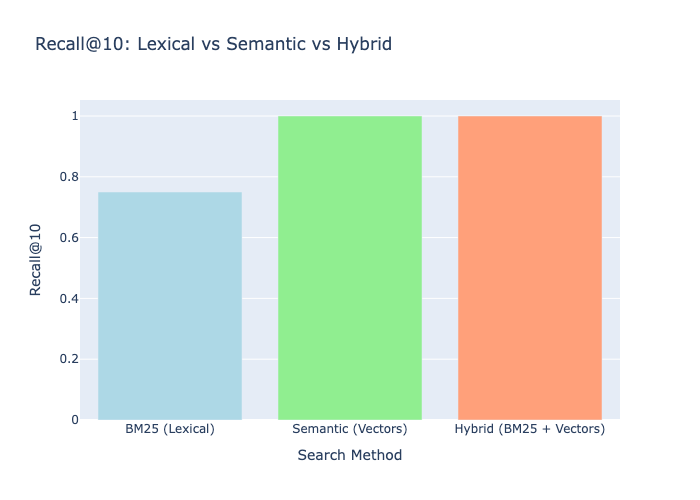

In [24]:
# Create visualization comparing recall across methods
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=comparison_df["method"].tolist(),
        y=comparison_df["recall@10"].tolist(),
        name="Recall@10",
        marker_color=["lightblue", "lightgreen", "lightsalmon"],
    )
)

fig.update_layout(
    title="Recall@10: Lexical vs Semantic vs Hybrid",
    xaxis_title="Search Method",
    yaxis_title="Recall@10",
    height=500,
)

fig.show(renderer="png")

## Cleanup

In [10]:
es.indices.delete(index=INDEX_NAME)
es.inference.delete(inference_id=INFERENCE_ENDPOINT_ID)

ObjectApiResponse({'acknowledged': True, 'pipelines': [], 'indexes': []})